In [1]:
import os
import re
import glob
import json
import time
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline

In [2]:
# 每部小说用滑动窗口采样得到若干等长片段，训练时，每个片段前一半作为输入，后一半作为输出
window_size=2000
window_stride=window_size//2
batch_size = 2048 # 批次大小

有效小说数量 457
三十三剑客图、书剑恩仇录、侠客行、倚天屠龙记、天龙八部、射雕英雄传、白马啸西风、碧血剑、神雕侠侣、笑傲江湖、越女剑、连城诀、雪山飞狐、飞狐外传、鸳鸯刀、鹿鼎记、一层楼、三刻拍案惊奇、三续金瓶梅、九尾龟、二刻拍案惊奇、二荷花史、僧尼孽海、八段锦、八美图、初刻拍案惊奇、剪灯新话、医界镜、十二楼、合浦珠、后红楼梦、听月楼、品花宝鉴、喻世明言、国色天香、型世言、夜雨秋灯录、好逑传、姑妄言、娱目醒心编、巫山艳史、常言道、平山冷燕、归莲梦、恨海、情变、情史、戏中戏、文明小史、新石头记、春秋配、杏花天、杜骗新书、林兰香、梦红楼梦、欢喜冤家、泪珠缘、浓情快史、海上花列传、灯月缘、灯草和尚、玉娇梨、玉楼春、生绡剪、生花梦、痴婆子传、石点头、空空幻、笔梨园、红楼圆梦、红楼复梦、红楼幻梦、红楼春梦、红楼梦、红楼梦影、红楼梦补、绣榻野史、绣鞋记、续红楼梦、续红楼梦新编、续红楼梦未竞稿、续金瓶梅、绮楼重梦、肉蒲团、花月痕、花神三妙传、萤窗清玩、蜃楼志、蝴蝶媒、补红楼梦、西湖二集、警世通言、警寤钟、负情侬传、赛花铃、连城璧、连城璧外编、醉醒石、醋葫芦、醒世姻缘传、醒世恒言、金云翘传、金屋梦、金瓶梅、铁花仙史、锦香亭、隔帘花影、青楼梦、风月梦、飞燕外传、飞花艳想、鸳鸯阵、南柯太守传、无双传、昆仑奴传、李娃传、柳毅传、柳氏传、河东记、灵应传、离魂记、红线传、聂隐娘、艳异编、艳异编续集、莺莺传、虬髯客传、谢小娥传、长恨传、霍小玉传、非烟传、龙城录、一枕奇、三宝太监西洋记、三春梦、世无匹、世说新语、东城老父传、东阳夜怪录、两晋秘史、中山狼传、丹忠录、九云记、乾隆下江南、二十四尊得道罗汉传、二度梅、于少保萃忠传、五美缘全传、人间乐、人面桃花、今古奇观、全相平话、八贤传、冥报记、冥音录、凤凰池、剑侠奇中奇全传、北梦琐言、北里志、十二笑、南村辍耕录、双凤奇缘、双龙传、古岳渎经、合锦回文传、后宋慈云走国全传、吴江雪、周秦行记、唐摭言、唐语林、唐阙史、商界现形记、善恶图全传、因话录、坐花志果、夜谭随录、大唐传载、大唐新语、大宋宣和遗事、大汉三合明珠宝剑全传、太平广记、女娲石、定命录、定情人、宣室志、崇祯惨史、巧联珠、幻中游、幽冥录、广异记、开元天宝遗事、开天传信记、引凤萧、归田录、情史、情梦柝、惊梦啼、扫迷帚、断鸿零雁记、新石头记、无声戏、无耻奴、明月台、明皇杂录、朝野佥载、本事诗、枕中记

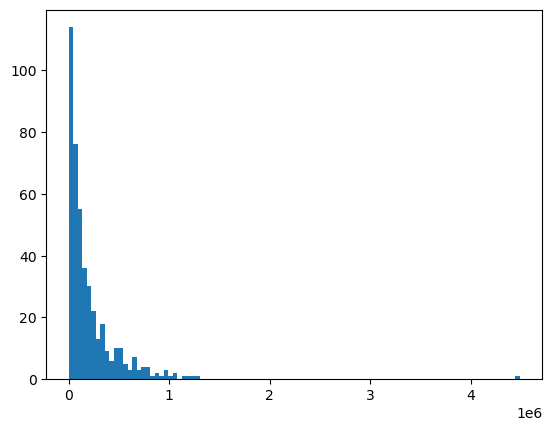

In [3]:
# Load the data
stop_words=[
    '\u3000',
    '　',
    ' ',
    '\r',
    '\n',
    '本书来自www.cr173.com免费txt小说下载站更多更新免费电子书请关注www.cr173.com',
    '----〖新语丝电子文库(www.xys.org)〗',
    'K□⒃谀歉鲂∩角鹕希?远远汀酢鮺Hx?KHK5DUJEnV.<dIUVxR;6Q4s;p#,Rt~}',
    '诹Ρ阆□跻淮危肺涔χK#,UfFxDZA&JG5ZR;R*~}',
    '按蘖蔚毒投纾炝加玫锻弦挥扒亨ァ币簧魑蕉危允恰皣Ｒ啷啷',
    '制台鹄矗岳砣袈！彼炖锼涫钦饷此担涫的茄皆缫雅踝潘掏玻谀抢锼藕蛄恕Ｄ歉鋈税盐胰玫娇妥铮约河眯渥臃魇昧艘巫樱胛易拢缓蠼庸掏玻鬃运蜕稀４耸币咽橇碛幸桓鲅剑萆喜枥戳恕Ｄ侨吮阄实溃骸澳銇薪纯瓷趺词榘。拷穸鲆焐趺词槟兀?',
    '(金庸)',
    '(na)',
    '笑傲江湖３１',
    '[完]',
    '（end）',
    '□',
    '',
    'doubleads（）;',
    '返回目录',
    '上一章',
    '下一章',
    '<图片>',
]
replace_words=[
    ('<<','《'),
    ('>>','》'),
    ('氵㸒','淫'), # 词向量没有'㸒'
]



titles=[]
novels=[]
for i in glob.glob('../text/*.txt'): # 金庸全集
    titles.append(i.split('\\')[-1].split('.')[0])
    with open(i, 'r', encoding='gb18030') as f:
        novel=f.read()
        
    for stop_word in stop_words: # 过滤非小说内容
        novel=novel.replace(stop_word,'')
    for k,v in replace_words:
        novel=novel.replace(k,v)
    
    novel = re.sub("[a-zA-Z0-9"+ re.escape('@$&<>:.,;-()') +"]{5,}", "", novel) # 删除连续的字母+数字，较短的可能是章节编号
    if len(novel)>=window_size:
        novels.append(novel)

for i in glob.glob('../text/chinese-novel-master/resources/*/*'):
    titles.append(i.split('\\')[-1].split('/')[-1])
    files = glob.glob(os.path.join(i, "*.html"))
    files.sort(key=lambda f: int(re.sub("\D", "", f))) # 按照数字顺序对文件进行排序

    
    with open(os.path.join(i, "info.json"),"r",encoding='utf-8') as f: # 将简介作为开头
        info = json.load(f)
        novel=info['intro']

    for file in files:
        with open(file, "r", encoding="utf-8") as f: # 打开并读取文件
            text = f.read() # 获取文件内容
            novel += text # 将文件内容添加到小说字符串中

    for stop_word in stop_words: # 过滤非小说内容
        novel=novel.replace(stop_word,'')
    for k,v in replace_words: # 替换特殊字符串
        novel=novel.replace(k,v)

    novel = re.sub("&[a-zA-Z0-9]+;", "", novel) # 删除html实体
    novel = re.sub("<[/]{0,1}[a-zA-Z0-9=:\"\'\\#/\\\\_\\.]+?>", "", novel) # 删除html标签
    novel = re.sub("[a-zA-Z0-9@\\$\\&<>:\\.,;\\-\\(\\)\'\"]{5,}", "", novel) # 删除连续的字母+数字，较短的可能是章节编号

    if len(novel)>=window_size:
        novels.append(novel)


all_string=''.join(novels)
print('有效小说数量',len(titles))
print('、'.join(titles))
print('总字数',len(all_string))
char_vocab=set(all_string)
print('字典规模',len(char_vocab))
length=[]
for id,novel in enumerate(novels):
    length.append(len(novel))
plt.hist(length,bins=100)
plt.show()

In [4]:
def read_vectors(path, topn=1400000):  # read top n word vectors, i.e. top is 10000
    lines_num, dim = 3, 300 # magic number
    vectors = [[0.]*dim,[-1.]*dim,[1.]*dim] # 未知、开始和结束标志
    iw = ['<pad>','<sos>','<eos>']
    wi = {
        '<pad>':0,
        '<sos>':1,
        '<eos>':2,
    }
    with open(path, encoding='utf-8', errors='ignore') as f:
        first_line = True
        for line in f:
            if first_line:
                first_line = False
                dim = int(line.rstrip().split()[1])
                continue
            lines_num += 1
            tokens = line.rstrip().split(' ')
            if tokens[0] not in char_vocab:
                continue
            vectors.append([float(x) for x in tokens[1:]])
            iw.append(tokens[0])
            if topn != 0 and lines_num >= topn:
                break
    for i, w in enumerate(iw):
        wi[w] = i
    print('读取完毕')
    return torch.Tensor(vectors), iw, wi, dim

vectors, iw, wi, dim = read_vectors('merge_sgns_bigram_char300.txt')
tokens = [torch.tensor([wi.get(c, wi['<pad>']) for c in novel]) for novel in novels] # 将文本转换为字编号
vectors.shape

In [6]:
# 定义一个自定义的Dataset类
class Seq2SeqDataset(Dataset):
    def __init__(self, tokens,wi,iw,vectors):
        
        self.tokens=tokens
        self.wi = wi
        self.iw = iw
        self.vectors = vectors.cuda()
        self.x=[]
        self.y=[] # 字id
        for novel in self.tokens:
            n_windows = (len(novel) - window_size) // window_stride + 1 # 滑动窗口的数量
            window = [novel[i * window_stride : i * window_stride + window_size] for i in range(n_windows)] # 滑动窗口采样
            window = torch.stack(window)
            self.x.append(window[:,:window_size//2])
            self.y.append(window[:,window_size//2:])
        self.x=torch.cat(self.x).cuda()
        self.y=torch.cat(self.y).cuda()
    
    def __len__(self):
        # 返回数据集的大小
        return len(self.x)
    
    def __getitem__(self, index):
        input_seq = self.x[index]
        output_seq = self.y[index]
        # 计算单词索引的嵌入，并在结尾添加<eos>标记
        EOS_id=2
        input_seq = torch.vstack([self.vectors[input_seq], self.vectors[EOS_id][None]])
        output_seq = torch.vstack([self.vectors[output_seq], self.vectors[EOS_id][None]])
        # 返回张量
        return input_seq, output_seq

dataset = Seq2SeqDataset(tokens,wi,iw,vectors)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size=dim
hidden_size = dim
output_size = dim
num_layers = 8 # 层数
dropout = 0.1

# 定义编码器类
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers, dropout=dropout) # GRU层，循环神经网络

    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden) # 将嵌入向量和隐藏状态输入GRU层，得到输出和新的隐藏状态
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device) # 初始化隐藏状态为全零向量

# 定义解码器类
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.activation = nn.LeakyReLU()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers, dropout=dropout) # GRU层，循环神经网络
        self.out = nn.Linear(hidden_size, output_size) # 线性层，将向量转换为词

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1) # 将输入转换为嵌入向量
        output = self.activation(output) # 使用ReLU激活函数
        output, hidden = self.gru(output, hidden) # 将嵌入向量和隐藏状态输入GRU层，得到输出和新的隐藏状态
        output = self.out(output[0]) # 将输出向量输入线性层和softmax层，得到概率分布
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device) # 初始化隐藏状态为全零向量


In [15]:
encoder=Encoder().cuda()
decoder=Decoder().cuda()
e_optimizer=optim.Adam([
    {'params':encoder.parameters(),'lr':0.01},
])
d_optimizer=optim.Adam([
    {'params':decoder.parameters(),'lr':0.01},
])

In [17]:
encoder_output, encoder_hidden = encoder(torch.zeros([8,20,300]).cuda(), torch.zeros([8,20,300]).cuda())

In [18]:
encoder_hidden.shape

torch.Size([8, 20, 300])

In [ ]:
for epoch in range(5):
    for input_seq, output_seq in dataloader:
        encoder_hidden = encoder.initHidden() # 初始化编码器的隐藏状态

        e_optimizer.zero_grad() # 清空编码器的梯度缓存
        d_optimizer.zero_grad() # 清空解码器的梯度缓存

        input_length = window_size
        target_length = window_size
        encoder_outputs = torch.zeros(window_size, encoder.hidden_size, device=device) # 初始化编码器的输出矩阵
        loss = 0 # 初始化损失值
        for ei in range(input_length): # 对于输入序列中的每个词
            encoder_output, encoder_hidden = encoder(input_seq[:,ei], encoder_hidden) # 将词和隐藏状态输入编码器，得到输出和新的隐藏状态
            encoder_outputs[ei] = encoder_output[0, 0] # 将输出存储到输出矩阵中对应的位置

        decoder_input = torch.tensor([[-1.]*dim], device=device) # 初始化解码器的输入为开始符号

        decoder_hidden = encoder_hidden # 将解码器的初始隐藏状态设为编码器的最终隐藏状态

        for di in range(target_length): # 对于目标序列中的每个词
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden) # 将词和隐藏状态输入解码器，得到输出和新的隐藏状态
            topv, topi = decoder_output.topk(1) # 获取输出中概率最大的词及其索引值
            decoder_input = topi.squeeze().detach() # 将索引值作为下一个解码器的输入

            loss += criterion(decoder_output, target_tensor[di]) # 计算损失值，并累加到总损失值中
            if decoder_input.item() == EOS_token: # 如果遇到结束符号，停止解码过程
                break

        loss.backward() # 反向传播计算梯度值

        e_optimizer.step() # 更新编码器的参数值
        d_optimizer.step() # 更新解码器的参数值

        return loss.item() / target_length # 返回平均损失值

In [ ]:
# 定义评估函数，用于生成小说续写
def evaluate(encoder,
             decoder,
             input_tensor,
             max_length=100):
    with torch.no_grad():
        
        encoder_hidden = encoder.initHidden()

        input_length = input_tensor.size()[0]
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output,
            encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)

        decoder_hidden = encoder_hidden

        decoded_words = [] # 存储生成的词语

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>') # 如果遇到结束符号，添加到生成序列中，并停止生成过程
                break 
            else:
                decoded_words.append(topi.item()) # 否则，添加到生成序列中，并继续生成过程

            decoder_input = topi.squeeze().detach()

    return decoded_words # 返回生成序列
